##### Copyright 2019 The TensorFlow Authors.
本資料は、TensorFlowチームによって提供されたサンプルを元に内容追記したものです。
Apache License 2.0 にて保護されているものですから、ご承知をお願いいたします。

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
# https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 言語理解のためのTransformerモデル

このチュートリアルでは、ポルトガル語を英語に翻訳する<a href="https://arxiv.org/abs/1706.03762" class="external">Transformerモデル</a>を訓練します。これは上級編のサンプルで、[テキスト生成](text_generation.ipynb)や[アテンション（注意機構）](nmt_with_attention.ipynb)の知識を前提としています。

Transformerモデルの背後にある中心的なアイデアは*セルフアテンション*、 つまり、シーケンスの表現を計算するために入力シーケンスの異なる位置に注意を払うことができることにあります。

Transformerモデルは、[RNNs](text_classification_rnn.ipynb)や[CNNs](../images/intro_to_cnns.ipynb)の代わりに セルフアテンション・レイヤーを重ねたものを使って、可変長の入力を扱います。この一般的なアーキテクチャにはいくつもの利点があります。

* データの中の時間的／空間的な関係を前提にしません。これは、オブジェクトの集合を扱うには理想的です。
* レイヤーの出力はRNNのような系列ではなく、並列に計算可能です。
* たくさんのRNNのステップや畳み込み層を経ることなく、離れた要素どうしが互いの出力に影響を与えることができます。
* 長距離の依存関係を学習可能です。これは、シーケンスを扱うタスクにおいては難しいことです。

このアーキテクチャの欠点は次のようなものです。

* 時系列では、あるタイムステップの出力が、入力とその時の隠れ状態だけからではなく、*過去全て*から計算されます。
* テキストのように、入力に時間的／空間的な関係が*存在する*場合、何らかの位置エンコーディングを追加しなければなりません。さもなければ、モデルは実質的にバッグ・オブ・ワードのようになってしまいます。

このノートブックのモデルを訓練したあとには、ポルトガル語の文を入力し、英語の翻訳を得ることができます。

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [2]:
# !pip install tensorflow_datasets
# !pip install tensorflow
# !pip install matplotlib
# !pip install pandas
# Pythonで利用する拡張機能を宣言する。
import tensorflow_datasets as tfds  # サンプルデータセット
import tensorflow as tf             # 深層学習ライブラリ
import time                         # 時間関数ライブラリ
import numpy as np                  # 数学関数ライブラリ
import matplotlib.pyplot as plt     # ビジュアライズライブラリ
import pprint                       # データ出力整然化ライブラリ
import pandas as pd                 # データ解析支援ライブラリ

## 入力パイプラインの設定

[TFDS](https://www.tensorflow.org/datasets)を使って、[TED Talks Open Translation Project](https://www.ted.com/participate/translate)から[Portugese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt)をロードします。

このデータセットには、約50000の訓練用サンプルと、1100の検証用サンプル、2000のテスト用サンプルが含まれています。

In [3]:
# TED Talks Open Translation Project ポルトガル語ー英語対訳コーパスの読み込み
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
# 訓練用データ、検証用データの取得
train_examples, val_examples = examples['train'], examples['validation']

In [4]:
# 訓練データの反復子を作成（順番にデータを取り出す機能）
i1 = iter(train_examples)
# ３回繰り返し
for i in range(3):
    # 次の訓練データを取り出す
    n = next(i1)
    # 取り出した訓練データを画面出力する
    print('record no {}.'.format(i))                        # レコード番号
    print('pt({}) : {}'.format(i, n[0].numpy().decode()))   # ポルトガル語
    print('en({}) : {}'.format(i, n[1].numpy().decode()))   # 英語
    print('\n')                                             # 改行

record no 0.
pt(0) : e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
en(0) : and when you improve searchability , you actually take away the one advantage of print , which is serendipity .


record no 1.
pt(1) : mas e se estes fatores fossem ativos ?
en(1) : but what if it were active ?


record no 2.
pt(2) : mas eles não tinham a curiosidade de me testar .
en(2) : but they did n't test for curiosity .




訓練用データセットから、カスタムのサブワード・トークナイザーを作成します。

In [5]:
# 訓練データセットから英語とポルトガル語のトークナイザーを作成（単語単位に切り分けてナンバーリングを行う）
# 元のデータセットは、ポルトガル語, 英語の組みが１レコードとして構成されている。
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        (en.numpy() for pt, en in train_examples), 
        target_vocab_size=2**13)
tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        (pt.numpy() for pt, en in train_examples), 
        target_vocab_size=2**13)

In [6]:
# トークナイザーの機能確認をしてみる。
# 確認を行う英語文
sample_string = 'Transformer is awesome.'
# 英語文よりトークナイズを行う（数値リストが返却される）
tokenized_string = tokenizer_en.encode(sample_string)
# トークナイズ内容を画面出力
print ('Tokenized string is {}'.format(tokenized_string))
# トークナイズ内容を英語分に戻す
original_string = tokenizer_en.decode(tokenized_string)
# 英語文を画面出力
print ('The original string: {}'.format(original_string))
# 元の英語文と生成された英語文が不一致の時はエラーを発生させる
assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


このトークナイザーは、単語が辞書にない場合には文字列をサブワードに分解してエンコードします。

In [7]:
# トークナイズ内容と実際の単語の関係を表示してみる。
# 数値リストを一つずつループ処理を実施
# TEDのコーパスに存在しないものは文字単位に分割される。
for ts in tokenized_string:
    print ('{:0>4} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
0013 ----> is 
2799 ----> awesome
7877 ----> .


In [8]:
BUFFER_SIZE = 20000     # データをシャフルする際のメモリサイズ
BATCH_SIZE = 64         # １回の学習で利用するデータのレコード数 (参考：https://qiita.com/kenta1984/items/bad75a37d552510e4682)

入力とターゲットに開始及び終了トークンを追加します。

In [9]:
# 関数定義を行う。この関数は、後ほど利用される。
# コーパスの文章の先頭と最後に開始・終了トークンを付与する。
# 開始トークンは最大値＋１、終了トークンは最大値＋２とする。
def encode(
        lang1,  #ポルトガル語の文章
        lang2): #英語の文章
    lang1 = ([tokenizer_pt.vocab_size] + 
            tokenizer_pt.encode(lang1.numpy()) + 
            [tokenizer_pt.vocab_size+1])
    lang2 = ([tokenizer_en.vocab_size] + 
            tokenizer_en.encode(lang2.numpy()) + 
            [tokenizer_en.vocab_size+1])
    # 開始・終了トークンが付与された、ポルトガル語と英語の数値配列
    return lang1, lang2

データセットの各要素にこの関数を適用するために、`Dataset.map`を使いたいと思います。`Dataset.map`はグラフモードで動作します。

* グラフテンソルは値を持ちません。
* グラフモードでは、TensorFlowの演算と関数しか使えません。

このため、この関数を直接`.map`することはできません。`tf.py_function`でラップする必要があります。`tf.py_function`は（値とそれにアクセスするための`.numpy()`メソッドを持つ）通常のテンソルを、ラップされたPython関数に渡します。

In [10]:
# Tensorflow型のデータをPython型の関数で処理を行わせるための変換処理
# 呼び出し元には、Tensorflow型のデータとして返却される
def tf_encode(
        pt,   # ポルトガル語の文章
        en):  # 英語の文章
    result_pt, result_en = tf.py_function(
            encode, 
            [pt, en], 
            [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])
    # 開始・終了トークンが付与された、ポルトガル語と英語の数値配列
    return result_pt, result_en

Note: このサンプルを小さく、より速くするため、長さが40トークンを超えるサンプルを削除します。

In [11]:
# 処理簡略化・高速化のために文章長を４０単語に制限する
MAX_LENGTH = 40

In [12]:
# xの文章とyの文章がどちらもmax_length個の単語数以下であるか検査をするフィルタ関数
def filter_max_length(
        x,                      # 文章x
        y,                      # 文章y
        max_length=MAX_LENGTH): # 最大単語数
    return tf.logical_and(
            tf.size(x) <= max_length, 
            tf.size(y) <= max_length)

In [13]:
# 訓練データセットの全文章に対し開始終了トークンを付与し、単語数４０以下のものだけにフィルタリング後、レコード順のシャフルを行う。
# .cache関数を使うことでオンメモリ化を行い、処理を高速化させる。
train_preprocessed = (
        train_examples
                .map(tf_encode)
                .filter(filter_max_length)
                .cache()
                .shuffle(BUFFER_SIZE))
# 検証データセットについても訓練データセットと同様だが、シャフルは不要。
val_preprocessed = (
        val_examples
                .map(tf_encode)
                .filter(filter_max_length))        

パディングとバッチ化の両方を行います。

In [14]:
# 訓練データセットをバッチサイズに切り出し、GPUが処理している間に、CPUで次のデータ準備を行うように設定
# 参考:https://qiita.com/Suguru_Toyohara/items/820b0dad955ecd91c7f3
train_dataset = (
        train_preprocessed
                .padded_batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE))
# 検証データセットをバッチサイズに切り出す。prefetch設定は不要
val_dataset = (
        val_preprocessed
                .padded_batch(BATCH_SIZE))

後でコードをテストするために、検証用データセットからバッチを一つ取得しておきます。

In [15]:
# データの一部を確認するため、検証データセットの１番目のミニバッチデータを取り出す。
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 20)
pt_batch, en_batch = next(iter(val_dataset))


In [16]:
# ポルトガル語の検証データセット１番目のミニバッチデータをpandasを利用して画面出力をしてみる。
print("[pt_batch]")
pd.DataFrame(pt_batch.numpy())


[pt_batch]


0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16  17  18    19   20    21   22    23    24  25    26  27  28  29  30  31  32  33  34  35  36  37
0   8214   342  3032    15  5917    20  4347  1189    17  1784  1412    29  8215     0     0     0     0   0   0     0    0     0    0     0     0   0     0   0   0   0   0   0   0   0   0   0   0   0
1   8214    95   198  6850  7990    14    44  6732     7     6  2211    15     4   555     2  8215     0   0   0     0    0     0    0     0     0   0     0   0   0   0   0   0   0   0   0   0   0   0
2   8214  4479  7990     9    20     7  5611     4  4416     4    10  4622  2878    20     9  1348  2682  97   2  8215    0     0    0     0     0   0     0   0   0   0   0   0   0   0   0   0   0   0
3   8214    25    27   278     5    42     8  3850  3308  8069     2  8215     0     0     0     0     0   0   0     0    0     0    0     0     0   0     0   0   0   0   0   0   0   0   0   0   0   0
4   8214    62  1181    15     7   122  3173  7990    33  3264  2745  5868   585     2  8215     0     0   0   0     0    0     0    0     0     0   0     0   0   0   0   0   0   0   0   0   0   0   0
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ..  ..   ...  ...   ...  ...   ...   ...  ..   ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
59  8214    27  1300    15     9  2810     3     9  1548     5    13     7  2130     1    25     8  7377   7  23  1780    3  4868  178  8003   232   2  8215   0   0   0   0   0   0   0   0   0   0   0
60  8214   195     1  2112     1  1673   100   111    33  5093  2081  6760  3057     2  8215     0     0   0   0     0    0     0    0     0     0   0     0   0   0   0   0   0   0   0   0   0   0   0
61  8214   584    12  2142  3184  3118   213    71     3  5473  7990  1093   140  2142  2659  6926  2414  11  55    42  403    12  162  4874  8073   2  8215   0   0   0   0   0   0   0   0   0   0   0
62  8214    59  1548     8   120  1430     1    69  2002     2  8215     0     0     0     0     0     0   0   0     0    0     0    0     0     0   0     0   0   0   0   0   0   0   0   0   0   0   0
63  8214   118    34    12   266   351   706  1919   468     6  7935  1275     7  1538     2  8215     0   0   0     0    0     0    0     0     0   0     0   0   0   0   0   0   0   0   0   0   0   0

[64 rows x 38 columns]

In [17]:
# 英語についても同様
print("[en_batch]")
pd.DataFrame(en_batch.numpy())

[en_batch]


0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16   17    18    19    20    21    22  23  24    25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
0   8087    98    25  1037  1903     4  7283    33  8088     0     0     0     0     0     0     0     0    0     0     0     0     0     0   0   0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
1   8087    12    20   260  5796    35   183  2955     4  1565   380     2  8088     0     0     0     0    0     0     0     0     0     0   0   0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   8087    12  5453    47    28     3  3176  1960     6     7  3730  1560  7863    59  1148  3254  7947    2  8088     0     0     0     0   0   0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
3   8087    23    12    84    16    13   367  1917  1923  1071  7932     2  8088     0     0     0     0    0     0     0     0     0     0   0   0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
4   8087    14    24  5938    43  5067    68  4573  7524   171   167     2  8088     0     0     0     0    0     0     0     0     0     0   0   0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...  ..  ..   ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
59  8087    12  2509     7  2031     5     7  1603    10   149  7941  7870    26   102    19     1    23   13  2626    60  1366     5  1079  19   2  8088   0   0   0   0   0   0   0   0   0   0   0   0   0   0
60  8087  1252     1    11    16   251     4   686     1    14   271    11     7    68  6453  7876  6833  263   150     2  8088     0     0   0   0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
61  8087    18  2059  1991    22  4008  6161   958  4365   864  1991    28   915     5    30    16   487   69   205  3639     2  8088     0   0   0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
62  8087    16  1436     8     9  2379     1  1581     2  8088     0     0     0     0     0     0     0    0     0     0     0     0     0   0   0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
63  8087    15    57    22    53    32  2036  5269     1     4  6465  1127  3344  1512     2  8088     0    0     0     0     0     0     0   0   0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

[64 rows x 40 columns]

.## 位置エンコーディング

このモデルには再帰や畳込みが含まれないので、モデルに文中の単語の相対的な位置の情報を与えるため、位置エンコーディングを追加します。

位置エンコーディングベクトルは埋め込みベクトルに加算します。埋め込みはトークンをd次元空間で表現します。そこでは、同じような意味を持つトークンが近くに位置することになります。しかし、埋め込みは単語の文中の相対的位置をエンコードしません。したがって、位置エンコーディングを加えることで、単語は、d次元空間の中で、*意味と文中の位置の近さ*にもとづいて近くに位置づけられます。

もう少し知りたければ [位置エンコーディング](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) のノートブックを参照してください。位置エンコーディングを計算する式は下記のとおりです。

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [18]:
# 位置エンコーディング角度の計算関数
def get_angles(
        pos,      # 文章中の単語位置
        i,        # 単語埋め込みの指定された次元
        d_model): # 単語埋め込みの全体次元数
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    # 角度を返却
    return pos * angle_rates

In [19]:
# 位置エンコーディング値の計算関数
def positional_encoding(
        position,   # 文章中の単語位置
        d_model):   # 単語埋め込みの全体次元数
    angle_rads = get_angles(
            np.arange(position)[:, np.newaxis], 
            np.arange(d_model)[np.newaxis, :], 
            d_model)
    # 配列中の偶数インデックスにはsinを適用; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # 配列中の奇数インデックスにはcosを適用; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    # 位置エンコーディグを返却
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


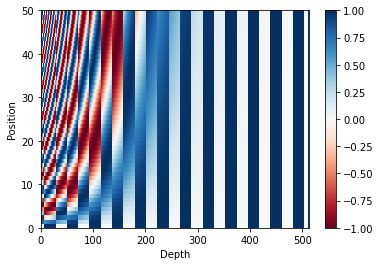

In [20]:
# 単語数50, 埋め込み次元512の位置エンコーディング配列の作成
pos_encoding = positional_encoding(50, 512)
# 位置エンコーディング配列の次元数を画面表示
print (pos_encoding.shape)
# ヒートマップの表示
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()
# 低い次元ほど周波数が高くなる。

## マスキング

シーケンスのバッチ中のパディングされた全てのトークンをマスクします。これにより、モデルがパディングを確実に入力として扱わないようにします。マスクは、パディング値`0`の存在を示します。つまり、`0`の場所で`1`を出力し、それ以外の場所では`0`を出力します。

In [21]:
# パディングマスク作成関数
# 入力されたseq行列のうち、値が０の部分のみ１とする行列を返却する。
def create_padding_mask(
        seq): # 複数の文章
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # アテンション・ロジットにパディングを追加するため
    # さらに次元を追加する
    # パディングマスクを返却する
    # (batch_size, 1, 1, seq_len)
    return seq[:, tf.newaxis, tf.newaxis, :]  

In [22]:
# パディングマスク作成関数の実験
x = tf.constant([[7, 6, 0, 0, 1], 
                 [1, 2, 3, 0, 0], 
                 [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

シーケンス中の未来のトークンをマスクするため、 ルックアヘッド・マスクが使われています。言い換えると、このマスクはどのエントリーを使うべきではないかを示しています。

これは、3番めの単語を予測するために、1つ目と2つ目の単語だけが使われるということを意味しています。同じように4つ目の単語を予測するには、1つ目、2つ目と3つ目の単語だけが使用され、次も同様となります。

In [23]:
# ルックアヘッドマスク作成関数
# デコーダーでは、先頭単語より順次処理をするため、後ろの単語をマスクするための行列を作成する
def create_look_ahead_mask(
        size):  # ルックアヘッドマスクの要素数
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    # ルックアヘッドマスクを返却する
    # (seq_len, seq_len)
    return mask

In [24]:
# ルックアヘッドマスク作成の実験
# 1x3の乱数生成
x = tf.random.uniform((1, 3))
# ルックアヘッドマスク作成
temp = create_look_ahead_mask(x.shape[1])
# 画面表示
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## スケール済み内積アテンション

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Transformerで使われているアテンション関数は3つの入力；Q(query), K(key), V(value)を取ります。このアテンションの重みの計算に使われている式は下記の通りです。

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

内積アテンションは、深度の平方根をファクターとしてスケールされています。これは、深度が大きくなると、内積が非常に大きくなり、ソフトマックス関数の勾配を計算すると非常に小さな値しか返さなくなってしまうためです。

例えば、`Q`と`K`が平均0分散1だと思ってください。これらの行列積は、平均0分散は`dk`となります。したがって、（他の数字ではなく）*`dk`の平方根*をスケーリングに使うことで、`Q` と `K` の行列積においても平均 0 分散 1 となり、緩やかな勾配を持つソフトマックスが得られることが期待できるのです。

マスクには、（負の無限大に近い）-1e9が設定されています。これは、マスクがQとKのスケール済み行列積と合計され、ソフトマックスの直前に適用されるからです。大きなマイナスの入力は、ゼロに近い出力となります。

In [25]:
def scaled_dot_product_attention(
        q,      # Q
        k,      # K
        v,      # V
        mask):  # パディングマスク
    """アテンションの重みの計算
    q, k, vは最初の次元が一致していること
    k, vは最後の2つの次元が一致していること
    マスクは型（パディングかルックアヘッドか）によって異なるshapeを持つが、
    加算の際にブロードキャスト可能であること
    引数：
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: (..., seq_len_q, seq_len_k) にブロードキャスト可能な
              shapeを持つ浮動小数点テンソル。既定値はNone
    戻り値：
        出力、アテンションの重み
    """
    # (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # matmul_qkをスケール（次元数を取得）
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # マスク指定ありの場合
    if mask is not None:
        # マスク部分を負の無限大にする。
        scaled_attention_logits += (mask * -1e9)
    # softmax は最後の軸(seq_len_k)について
    # 合計が1となるように正規化
    # (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    # 結果・アテンションの重みを返却
    return output, attention_weights

ソフトマックス正規化がKに対して行われるため、その値がQに割り当てる重要度を決めることになります。

出力は、アテンションの重みとV(value)ベクトルの積を表しています。これにより、注目したい単語がそのまま残され、それ以外の単語は破棄されます。

In [26]:
# Scaled Dot Product Attention結果確認関数
def print_out(
        q,  # Q
        k,  # K
        v): # V
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [27]:
# Scaled Dot Product Attentionの実験
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)
temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)
# この`query`は2番目の`key`に割り付けられているので
# 2番めの`value`が返される
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [28]:
# このクエリは（3番目と 4番目の）繰り返しキーに割り付けられるので
# 関連した全ての値が平均される
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [29]:
# このクエリは最初と2番めのキーに等しく割り付けられるので
# それらの値が平均される
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


すべてのクエリをまとめます。

In [30]:
temp_q = tf.constant(
        [[0, 0, 10], 
         [0, 10, 0], 
         [10, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## マルチヘッド・アテンション

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


マルチヘッド・アテンションは4つのパートから成っています。
* 線形レイヤーとマルチヘッドへの分割
* スケール済み内積アテンション
* マルチヘッドの結合
* 最終線形レイヤー


各マルチヘッド・アテンション・ブロックは3つの入力：Q(query), K(key), V(value)を取ります。
これらは、線形（Dense）レイヤーを通され、マルチヘッドに分割されます。

上記で定義した`scaled_dot_product_attention`は（効率のためにブロードキャストで）各ヘッドに適用されます。アテンション・ステップにおいては、適切なマスクを使用しなければなりません。その後、各ヘッドのアテンション出力は（`tf.transpose`と`tf.reshape`を使って）結合され、最後の`Dense`レイヤーに通されます。

単一のアテンション・ヘッドのかわりに、Q、K、およびVは複数のヘッドに分割されます。なぜなら、それによって、モデルが異なる表現空間の異なる位置の情報について、連携してアテンションを計算できるからです。また、分割後の各ヘッドの次元を小さくすることで、全体の計算コストを、すべての次元を持つ単一のアテンション・ヘッドを用いた場合と同一にできます。

In [31]:
# Multi Head Attention classの作成
class MultiHeadAttention(tf.keras.layers.Layer):
    # 初期化処理
    def __init__(
            self,       # クラスインスタンス
            d_model,    # 埋め込み次元数
            num_heads): # 分割数
        # 親クラスの初期化
        super(MultiHeadAttention, self).__init__()
        # ヘッド数をクラス変数に保存
        self.num_heads = num_heads
        # 埋め込み次元数をクラス変数に保存
        self.d_model = d_model
        # 各ヘッドの次元が同じにならない場合エラーにする。
        assert d_model % self.num_heads == 0
        # 各ヘッドの次元数をクラス変数に保存
        self.depth = d_model // self.num_heads
        # QKV全結合レイヤーオブジェクトをクラス変数に保存
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        # 最終線形レイヤーオブジェクトをクラス変数に保存
        self.dense = tf.keras.layers.Dense(d_model)
    # ヘッド分割処理
    def split_heads(
          self,         # クラスインスタンス
          x,            # 行列
          batch_size):  # バッチサイズ
        """最後の次元を(num_heads, depth)に分割。
        結果をshapeが(batch_size, num_heads, seq_len, depth)となるように
        リシェイプする。
        """
        #ヘッド数、各ヘッドの次元数に行列変換
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        #次元要素順序の変更
        return tf.transpose(x, perm=[0, 2, 1, 3])
    # Multi Head Attention classの実行メソッド v:value k:key q:query    
    def call(
            self,   # クラスインスタンス
            v,      # V
            k,      # K
            q,      # Q
            mask):  # パディングマスク
        batch_size = tf.shape(q)[0]
        # (batch_size, seq_len, d_model)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        # (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        # scaled_attention.shape == 
        #       (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == 
        #       (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
                q, k, v, mask)
        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(
                scaled_attention, 
                perm=[0, 2, 1, 3])
        # (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(
                scaled_attention, 
                (batch_size, -1, self.d_model))
        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        # 結果・アテンションの重みを返却
        return output, attention_weights

試しに、`MultiHeadAttention`レイヤーを作ってみましょう。シーケンス `y` の各位置において、`MultiHeadAttention` はシーケンスのすべての位置に対して8つのヘッドを用いてアテンションを計算し、各位置それぞれで同じ長さの新しいベクトルを返します。

In [32]:
# Multi Head Attentionの実験
#８分割ヘッドの準備
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
# (batch_size, encoder_sequence, d_model) 乱数行列の生成
y = tf.random.uniform((1, 60, 512))
# all メソッドの呼び出し
out, attn = temp_mha(y, k=y, q=y, mask=None)
# 出力、アテンションの重みのそれぞれの行列サイズを画面表示
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## ポイントワイズのフィードフォワード・ネットワーク

ポイントワイズのフィードフォワード・ネットワークは、2つの全結合層とそれをつなぐReLU活性化層からなります。

In [33]:
# 全結合ネットワークの作成関数
def point_wise_feed_forward_network(
        d_model,  # 埋め込みの次元数
        dff):     # 中間層の次元数
    return tf.keras.Sequential([
        # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(dff, activation='relu'),
        # (batch_size, seq_len, d_model)
        tf.keras.layers.Dense(d_model)])

In [34]:
# 全結合ネットワークの実験
# 入力512次元、出力2048次元のレイヤー作成
sample_ffn = point_wise_feed_forward_network(512, 2048)
# 乱数投入での結果行列サイズの画面表示
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## エンコーダーとデコーダー

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Transformerモデルは、標準の[アテンション付きシーケンス・トゥー・シーケンスモデル](nmt_with_attention.ipynb)と同じ一般的なパターンを踏襲します。

* 入力の文は、`N`層のエンコーダー・レイヤーを通り、シーケンス中の単語／トークンごとに出力を生成する。
* デコーダーは、エンコーダーの出力と自分自身の入力（セルフアテンション）に注目し、次の単語を予測する。

### エンコーダー・レイヤー

それぞれのエンコーダー・レイヤーは次のようなサブレイヤーから成っています。

1.  マルチヘッド・アテンション（パディング・マスク付き）
2.  ポイントワイズ・フィードフォワード・ネットワーク

サブレイヤーにはそれぞれ残差接続があり、その後にレイヤー正規化が続きます。残差接続は、深いネットワークでの勾配消失問題を回避するのに役立ちます。

それぞれのサブレイヤーの出力は`LayerNorm(x + Sublayer(x))`です。正規化は、（最後の）`d_model`軸に対して行われます。TransformerにはN層のエンコーダーがあります。

In [35]:
# エンコーダーレイヤークラスの作成（ポルトガル語入力側）
class EncoderLayer(tf.keras.layers.Layer):
    # 初期化処理
    def __init__(
            self,       # クラスインスタンス
            d_model,    # 埋め込み次元数
            num_heads,  # ヘッド数
            dff,        # 全結合中間層次元数
            rate=0.1):  # Dropout割合
        # 親クラスの初期化
        super(EncoderLayer, self).__init__()
        # マルチヘッドアテンション層作成
        self.mha = MultiHeadAttention(d_model, num_heads)
        # 全結合層作成
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        # 残差接続層(MultiHead側、全結合層側)作成
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Dropout(MultiHead側、全結合層側)作成
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    # 実行処理
    def call(
            self,     # クラスインスタンス
            x,        # QKVとなる行列
            training, # 訓練モード？
            mask):    # パディングマスク
        # attn_output:MultiHeadAttention結果
        attn_output, _ = self.mha(x, x, x, mask)
        # attn_output:dropout結果
        attn_output = self.dropout1(attn_output, training=training)
        # out1:残差接続結果
        out1 = self.layernorm1(x + attn_output)
        # ffn_output:全結合結果
        ffn_output = self.ffn(out1)
        # ffn_output:dropout結果
        ffn_output = self.dropout2(ffn_output, training=training)
        # out2:残差接続結果
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

In [36]:
# エンコーダレイヤークラスの実験
# 埋め込み512次元、８ヘッド、全結合中間2048次元のEncoderLayerを作成
sample_encoder_layer = EncoderLayer(512, 8, 2048)
# バッチサイズ64, 入力データ43, 埋め込み512次元のデータを乱数生成　訓練=false　マスクなし で呼び出し
sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)
# 返却されたデータ構造を確認
# (batch_size, input_seq_len, d_model)
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

### デコーダー・レイヤー

各デコーダー・レイヤーは次のようなサブレイヤーからなります。

1. マスク付きマルチヘッド・アテンション（ルックアヘッド・マスクおよびパディング・マスク付き）
2. （パディング・マスク付き）マルチヘッド・アテンション。V(value) と K(key) は*エンコーダーの出力*を入力として受け取る。Q(query)は*マスク付きマルチヘッド・アテンション・サブレイヤー*の出力を受け取る。
3. ポイントワイズ・フィードフォワード・ネットワーク

各サブレイヤーは残差接続を持ち、その後にレイヤー正規化が続きます。各サブレイヤーの出力は`LayerNorm(x + Sublayer(x))`です。正規化は、（最後の）`d_model`軸に沿って行われます。

Transformerには、N層のデコーダー・レイヤーが存在します。

Qがデコーダーの最初のアテンション・ブロックの出力を受け取り、Kがエンコーダーの出力を受け取るとき、アテンションの重みは、デコーダーの入力の、エンコーダーの出力に対する重要度を表します。言い換えると、デコーダーは、エンコーダーの出力と自分自身の出力のセルフ・アテンションを見て、次の単語を予想します。上記の、スケール済み内積アテンションのセクションのデモを参照してください。

In [37]:
# デコーダレイヤークラスの作成（英語生成側）
class DecoderLayer(tf.keras.layers.Layer):
    # 初期化処理
    def __init__(
            self,       # クラスインスタンス
            d_model,    # 埋め込み次元数
            num_heads,  # ヘッド数
            dff,        # 全結合中間層次元数
            rate=0.1):  # Dropout割合
        # 親クラス初期化
        super(DecoderLayer, self).__init__()
        # マルチヘッド層１の作成（英語の入力部分）
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        # マルチヘッド層２の作成（ポルトガル語と英語の結合部分）
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        # 全結合層の作成
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        # 残差接続（マルチヘッド層１、２、全結合層）の作成
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Dropout（マルチヘッド層１、２、全結合層）の作成
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)      
    # 実行処理
    def call(
            self,             # クラスインスタンス
            x,                # QKVとなる行列
            enc_output,       # エンコーダ出力
            training,         # 訓練モード？
            look_ahead_mask,  # ルックアヘッドマスク
            padding_mask):    # パディングマスク
        # attn1:MHA結果 attn_weights_block1:アテンション行列
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        # attn1:dropout結果
        attn1 = self.dropout1(attn1, training=training)
        # out1:残差接続結果
        out1 = self.layernorm1(attn1 + x)
        # attn2:MHA結果 attn_weights_block2:アテンション行列
        attn2, attn_weights_block2 = self.mha2(
                enc_output, 
                enc_output, 
                out1, 
                padding_mask)
        # attn2:dropout結果
        attn2 = self.dropout2(attn2, training=training)
        # out2:残差接続結果
        out2 = self.layernorm2(attn2 + out1)
        # ffn_output:全結合結果
        ffn_output = self.ffn(out2)
        # ffn_output:dropout結果
        ffn_output = self.dropout3(ffn_output, training=training)
        # out3:残差接続結果
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

In [38]:
# デコーダレイヤークラスの実験
# 埋め込み512次元、８ヘッド、全結合中間2048次元のEncoderLayerを作成
sample_decoder_layer = DecoderLayer(512, 8, 2048)
# バッチサイズ64, 入力データ50, 埋め込み512次元のデータを乱数生成
sample_decoder_layer_output, _, _ = sample_decoder_layer(
        tf.random.uniform((64, 50, 512)),
        sample_encoder_layer_output,        # Encoder出力結果
        False,                              # 訓練モード False
        None,                               # パディングマスクなし
        None)                               # ルックアヘッドマスクなし
# 返却されたデータ構造を確認
# (batch_size, target_seq_len, d_model)
sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

### エンコーダー

`Encoder`は次のものからできています。

1.  入力の埋め込み
2.  位置エンコーディング
3.  N 層のエンコーダー・レイヤー

入力は埋め込み層を通り、位置エンコーディングと合算されます。この加算の出力がエンコーダー・レイヤーの入力です。エンコーダーの出力はデコーダーの入力になります。

In [39]:
# エンコーダクラスの作成
class Encoder(tf.keras.layers.Layer):
    #初期化処理
    def __init__(
            self,                       # クラスインスタンス
            num_layers,                 # エンコード繰り返し数
            d_model,                    # 埋め込み次元数
            num_heads,                  # ヘッド数
            dff,                        # 全結合中間次元数
            input_vocab_size,           # 入力側言語語彙数
            maximum_position_encoding,  # 位置エンコーディング最大位置
            rate=0.1):                  # Dropout割合
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        #埋め込み層の作成
        self.embedding = tf.keras.layers.Embedding(
                input_vocab_size, 
                d_model)
        #位置エンコーディングの作成
        self.pos_encoding = positional_encoding(
                maximum_position_encoding, 
                self.d_model)
        #繰り返し数分のエンコーダレイヤ作成
        self.enc_layers = [EncoderLayer(
                d_model, 
                num_heads, 
                dff, 
                rate) for _ in range(num_layers)]
        #Dropoutの作成
        self.dropout = tf.keras.layers.Dropout(rate)
    # 実行処理
    def call(
            self,     # クラスインスタンス
            x,        # 入力文章
            training, # 訓練モード？
            mask):    # パディングマスク
        # 文章の単語数
        seq_len = tf.shape(x)[1]
        # x:埋め込み結果
        x = self.embedding(x)
        # x:値の正規化
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # x:位置エンコーディング加算
        x += self.pos_encoding[:, :seq_len, :]
        # x:dropout結果
        x = self.dropout(x, training=training)
        # エンコーダレイヤ繰り返し実行
        for i in range(self.num_layers):
            # x:エンコード結果
            x = self.enc_layers[i](x, training, mask)
        # (batch_size, input_seq_len, d_model)
        return x

In [40]:
# エンコーダクラスの実験
# エンコーダを作成
sample_encoder = Encoder(
        num_layers=2,                       # 繰り返し数
        d_model=512,                        # 埋め込み次元数
        num_heads=8,                        # ヘッド数
        dff=2048,                           # 全結合中間次元数
        input_vocab_size=8500,              # 入力言語語彙数
        maximum_position_encoding=10000)    # 位置エンコーディング最大
# 64 x 62 乱数行列作成
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
# エンコーダー呼び出し
sample_encoder_output = sample_encoder(
        temp_input,     # サンプルデータ
        training=False, # 訓練 False
        mask=None)      # マスクなし
# 返却されたデータ構造を確認
print (sample_encoder_output.shape)

(64, 62, 512)


### デコーダー

`Decoder` は次のもとからできています。
 
1.   出力埋め込み
2.   位置エンコーディング
3.   N 層のデコーダー・レイヤー

ターゲットは埋め込みを通り、位置エンコーディングと加算されます。この加算の出力がデコーダーの入力になります。デコーダーの出力は、最後の線形レイヤーの入力となります。

In [41]:
# デコーダクラスの作成
class Decoder(tf.keras.layers.Layer):
    # 初期化処理
    def __init__(
            self,                       # クラスインスタンス
            num_layers,                 # デコード繰り返し数
            d_model,                    # 埋め込み次元数
            num_heads,                  # ヘッド数
            dff,                        # 全結合中間次元数
            target_vocab_size,          # 出力側言語語彙数
            maximum_position_encoding,  # 位置エンコーディング最大位置
            rate=0.1):                  # Dropout割合
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        # 埋め込み層の作成
        self.embedding = tf.keras.layers.Embedding(
                target_vocab_size, 
                d_model)
        # 位置エンコーディングの作成
        self.pos_encoding = positional_encoding(
                maximum_position_encoding, 
                d_model)
        # 繰り返し数分のデコーダレイヤ作成
        self.dec_layers = [
                DecoderLayer(
                    d_model, 
                    num_heads, 
                    dff, 
                    rate) for _ in range(num_layers)]
        # Dropoutの作成
        self.dropout = tf.keras.layers.Dropout(rate)      
    # 実行処理
    def call(
            self,             # クラスインスタンス
            x,                # 出力文章
            enc_output,       # エンコーダ出力
            training,         # 訓練モード？
            look_ahead_mask,  # ルックアヘッドマスク
            padding_mask):    # パディングマスク
        # 文章の単語数
        seq_len = tf.shape(x)[1]
        # アテンション重み保持変数
        attention_weights = {}
        # x:埋め込み結果
        x = self.embedding(x)
        # x:値の正規化
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # x:位置エンコーディング加算
        x += self.pos_encoding[:, :seq_len, :]
        # x:dropout結果
        x = self.dropout(x, training=training)
        # デコーダーレイヤ繰り返し実行
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](
                    x,                # 出力文書
                    enc_output,       # エンコーダ出力
                    training,         # 訓練？
                    look_ahead_mask,  # ルックアヘッドマスク
                    padding_mask)     # パディングマスク
            # decoder_layer?_block? というラベルでアテンション重みを保存
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        # 出力結果と全てのレイヤーのアテンション重みを返却
        return x, attention_weights

In [42]:
# デコーダクラスの実験
# デコーダを作成
sample_decoder = Decoder(
        num_layers=2,                       # 繰り返し数
        d_model=512,                        # 埋め込み次元数
        num_heads=8,                        # ヘッド数
        dff=2048,                           # 全結合中間次元数
        target_vocab_size=8000,             # 出力言語語彙数
        maximum_position_encoding=5000)     # 位置エンコーディング最大値
# 64 x 26 乱数行列作成
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)
# デコーダ呼び出し エンコーダ出力は、上記実験で作成したもの 訓練FALSE マスクなし
output, attn = sample_decoder(
        temp_input,                         # サンプルデータ
        enc_output=sample_encoder_output,   # エンコーダの出力
        training=False,                     # 訓練 False
        look_ahead_mask=None,               # ルックアヘッドマスクなし
        padding_mask=None)                  # パディングマスクなし
# 返却されたデータとアテンション重み（ヘッド数分）の構造を確認
output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformerの作成

 Transformerは、エンコーダー、デコーダーと、最後の線形レイヤーからなります。デコーダーの出力は、線形レイヤーの入力であり、その出力が返されます。

In [43]:
# トランスフォーマクラスの作成
class Transformer(tf.keras.Model):
    # 初期化処理
    def __init__(
            self,               # クラスインスタンス
            num_layers,         # エンコード・デコード繰り返し数
            d_model,            # 埋め込み次元数
            num_heads,          # ヘッド数
            dff,                # 全結合中間次元数
            input_vocab_size,   # 入力側言語語彙数
            target_vocab_size,  # 出力側言語語彙数
            pe_input,           # 位置エンコーディング最大位置（入力側）
            pe_target,          # 位置エンコーディング最大位置（出力側）
            rate=0.1):          # Dropout割合
        # 親クラス初期化
        super(Transformer, self).__init__()
        # エンコーダの作成
        self.encoder = Encoder(
                num_layers,       # 繰り返し数
                d_model,          # 埋め込み次元数
                num_heads,        # ヘッド数
                dff,              # 全結合中間次元数
                input_vocab_size, # 入力側言語語彙数
                pe_input,         # 位置エンコーディング最大位置
                rate)             # Dropout割合
        # デコーダの作成
        self.decoder = Decoder(
                num_layers,       # 繰り返し数
                d_model,          # 埋め込み次元数
                num_heads,        # ヘッド数
                dff,              # 全結合中間次元数
                target_vocab_size,# 出力側言語語彙数
                pe_target,        # 位置エンコーディング最大位置
                rate)             # Dropout割合
        # 全結合層の作成
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)      
    # 実行処理
    def call(
            self,                 # クラスインスタンス
            inp,                  # 入力文書
            tar,                  # 出力文書
            training,             # 訓練モード？
            enc_padding_mask,     # パディングマスク（入力側）
            look_ahead_mask,      # ルックアヘッドマスク（出力側）
            dec_padding_mask):    # パディングマスク（出力側）
        # enc_output:エンコード結果
        enc_output = self.encoder(inp, training, enc_padding_mask)
        # dec_output:デコード結果 attention_weights:アテンション重み
        dec_output, attention_weights = self.decoder(
                tar,              # 出力文章
                enc_output,       # エンコーダ出力
                training,         # 訓練モード？
                look_ahead_mask,  # ルックアヘッドマスク（出力側）
                dec_padding_mask) # パディングマスク（出力側）
        # final_output:全結合結果
        final_output = self.final_layer(dec_output)
        # 結果、アテンション重みを返却する
        # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

In [44]:
# トランスフォーマクラスの実験
#  エンコードデコード繰り返し 2, 埋め込み次元数 512, ヘッド数 8, 全結合中間層次元数 2048, 入力語彙数 8500, 出力語彙数 8000
#  入力側位置エンコーディング最大 10000, 出力側位置エンコーディング最大 6000
sample_transformer = Transformer(
        num_layers=2,           # 繰り返し数
        d_model=512,            # 埋め込み次元数
        num_heads=8,            # ヘッド数
        dff=2048,               # 全結合中間次元数
        input_vocab_size=8500,  # 入力側言語語彙数
        target_vocab_size=8000, # 出力側言語語彙数
        pe_input=10000,         # 位置エンコーディング最大位置（入力）
        pe_target=6000)         # 位置エンコーディング最大位置（出力）
# 入力データ(64x38)を乱数作成
temp_input = tf.random.uniform(
        (64, 38), 
        dtype=tf.int64, 
        minval=0, 
        maxval=200)
# 出力データ(64x36)を乱数作成
temp_target = tf.random.uniform(
        (64, 36), 
        dtype=tf.int64, 
        minval=0, 
        maxval=200)
# トランスフォーマ実行
fn_out, _ = sample_transformer(
        temp_input, 
        temp_target, 
        training=False, 
        enc_padding_mask=None, 
        look_ahead_mask=None, 
        dec_padding_mask=None)
# 結果構造画面表示
# (batch_size, tar_seq_len, target_vocab_size)
fn_out.shape

TensorShape([64, 36, 8000])

## ハイパーパラメーターの設定

このサンプルを小さく、比較的高速にするため、 *num_layers, d_model, and dff*の値は小さくされています。

Transformerのベースモデルで使われている値は*num_layers=6*, *d_model = 512*, *dff = 2048*です。 Transformerの他のバージョンについては、[論文](https://arxiv.org/abs/1706.03762)を参照してください。

Note: 下記の値を変更することで、さまざまなタスクでSoTA（訳注：State of The Art、その時点での最高性能）を達成したモデルが得られます。

In [45]:
# 実際の稼働環境パラメータの設定
# Encoder,Decoderの繰り返し数
num_layers = 4
# 埋め込みの次元数
d_model = 128
# 全結合中間層次元数
dff = 512
# ヘッド数
num_heads = 8
# 入力言語の語彙＋開始・終了トークンの数
input_vocab_size = tokenizer_pt.vocab_size + 2
# 出力言語の語彙＋開始・終了トークンの数
target_vocab_size = tokenizer_en.vocab_size + 2
# Dropout割合
dropout_rate = 0.1

## オプティマイザー

[論文](https://arxiv.org/abs/1706.03762)の中の式に従って、カスタムの学習率スケジューラーを持った、Adamオプティマイザーを使用します。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [46]:
# 学習率のカスタムスケジューラクラスの作成 warmupを指定し、そこまで学習率を増加、それ以降の学習率を減衰させる。
# 参考 https://qiita.com/omiita/items/d24568a835da6911b01e
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    # 初期化処理:
    def __init__(
            self,               # クラスインスタンス
            d_model,            # 埋め込み次元数
            warmup_steps=4000): # warmupステップ数
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(
            self,   # クラスインスタンス
            step):  # ステップ数
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [47]:
# オプティマイザの作成
# 学習率のカスタムスケジューラの作成
learning_rate = CustomSchedule(d_model)
# Adamオプティマイザを作成
# 参考 https://qiita.com/omiita/items/1735c1d048fe5f611f80
optimizer = tf.keras.optimizers.Adam(
        learning_rate, 
        beta_1=0.9, 
        beta_2=0.98, 
        epsilon=1e-9)

Text(0.5, 0, 'Train Step')

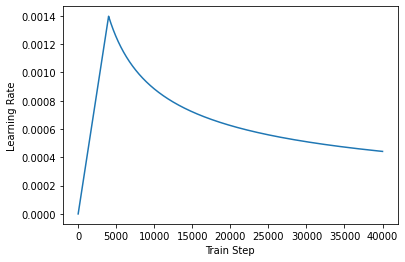

In [48]:
# 学習率変化の確認
temp_learning_rate_schedule = CustomSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 損失とメトリクス

ターゲットシーケンスはパディングされているため、損失を計算する際にパディング・マスクを適用することが重要です。

In [49]:
# 損失関数オブジェクトの作成
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, 
        reduction='none')

In [50]:
# 損失関数の作成
def loss_function(
        real,   # 真の正解文章
        pred):  # 予測された文章
    # 値が0以外の部分のマスクを作成
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 損失関数オブジェクトを呼び出し
    loss_ = loss_object(real, pred)
    # マスクの変数型を合わせる
    mask = tf.cast(mask, dtype=loss_.dtype)
    # マスク適用で有効値のみ取り出す
    loss_ *= mask
    # 平均値を返却する
    return tf.reduce_mean(loss_)

In [51]:
# kerasが提供している損失値オブジェクトを保存
train_loss = tf.keras.metrics.Mean(name='train_loss')
# kerasが提供している正解率オブジェクトを保存
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

## 訓練とチェックポイント生成

In [52]:
# 訓練を行うためにTransformerオブジェクトを作成する。
transformer = Transformer(
        num_layers,                     # 繰り返し数
        d_model,                        # 埋め込み次元数
        num_heads,                      # ヘッド数
        dff,                            # 全結合中間次元数
        input_vocab_size,               # 入力言語側語彙数
        target_vocab_size,              # 出力言語側語彙数
        pe_input=input_vocab_size,      # 位置エンコーディング最大位置（入力）
        pe_target=target_vocab_size,    # 位置エンコーディング最大位置（出力）
        rate=dropout_rate)              # Dropout割合

In [53]:
# マスクを作成する inp:入力側 tar:出力側
def create_masks(
        inp,  # 入力側文章
        tar): # 出力側文章
    # エンコーダ・デコーダパディング・マスク
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    # デコーダルックアヘッドマスク
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    # パディングマスクとルックアヘッドマスクを合成する。
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    # エンコーダパディングマスク、合成マスク、デコーダパディングマスクを返却する。
    return enc_padding_mask, combined_mask, dec_padding_mask

チェックポイントのパスとチェックポイント・マネージャーを作成します。これは、`n`エポックごとにチェックポイントを保存するのに使用されます。

In [54]:
# チェックポイントマネージャーの設定
# 何度も学習するのは時間がかかるので、学習済みパラメータをチェックポイントファイルとして
# 保存を行う。
# 既にチェックポイントファイルが存在する場合、そのパラメータを読み込む
# チェックポイントファイルの場所
checkpoint_path = "./checkpoints/train"
# チェックポイントオブジェクトの作成
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
# チェックポイントマネージャーオブジェクトの作成
ckpt_manager = tf.train.CheckpointManager(
        ckpt, 
        checkpoint_path, 
        max_to_keep=5)
# チェックポイントが存在したなら、最後のチェックポイントを復元する。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

ターゲットは、tar_inpとtar_realに分けられます。tar_inpはデコーダーの入力として渡されます。`tar_real`は同じ入力を1つシフトしたものです。`tar_input`の位置それぞれで、`tar_real`は予測されるべき次のトークンを含んでいます。

たとえば、`sentence` = "SOS A lion in the jungle is sleeping EOS" だとすると、次のようになります。

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

Transformerは、自己回帰モデルです。1回に1箇所の予測を行い、その出力を次に何をすべきかの判断に使用します。

訓練時にこのサンプルは[テキスト生成チュートリアル](./text_generation.ipynb)のように、ティーチャーフォーシングを使用します。ティーチャーフォーシングとは、その時点においてモデルが何を予測したかに関わらず、真の出力を次のステップに渡すというものです。

Transformerが単語を予測するたびに、*セルフアテンション*のおかげで次の単語を予測するために入力シーケンスの過去の単語を参照することができます。

モデルが期待される出力を盗み見ることがないように、モデルはルックアヘッド・マスクを使用します。

In [55]:
# 訓練時エポック数設定（一つの訓練データを何回繰り返して学習させるか）
EPOCHS = 20

In [56]:
# 訓練関数の作成
# @tf.functionは高速に実行するためにtrain_stepをTFグラフにトレースコンパイルします。
# この関数は、引数となるテンソルのshapeに特化したものです。
# シーケンスの長さや（最後のバッチが小さくなるなど）バッチサイズが可変となることによって
# 再トレーシングが起きないようにするため、input_signatureを使って、より一般的なshapeを
# 指定します。
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
@tf.function(input_signature=train_step_signature)
def train_step(
        inp,  # 入力文書
        tar): # 出力文書
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:] 
    # マスクの作成
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            inp, 
            tar_inp)
    # 入力変数に対する計算結果の勾配を計算・管理するための勾配テープをオープンする。
    with tf.GradientTape() as tape:
        # 訓練の実行
        predictions, _ = transformer(
                inp,              # 入力文章
                tar_inp,          # 出力文書
                True,             # 訓練モード True
                enc_padding_mask, # パディングマスク（入力側）
                combined_mask,    # 混合マスク
                dec_padding_mask) # パディングマスク（出力側）
        # 損失値の取得
        loss = loss_function(tar_real, predictions)
        # 訓練可能パラメータの微分を行う
    gradients = tape.gradient(loss, transformer.trainable_variables)
    # 訓練可能パラメータの更新を行う
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    # 損失値を設定
    train_loss(loss)
    # 正解率を設定
    train_accuracy(tar_real, predictions)

ポルトガル語を入力言語とし、英語をターゲット言語とします。

In [57]:
# 訓練の実行
# 学習済みの場合、再学習を行わない。
if not ckpt_manager.latest_checkpoint:
    # EPOCHSの回数だけ繰り返す
    for epoch in range(EPOCHS):
        # 開始時間を保存
        start = time.time()
        # 損失値をクリア
        train_loss.reset_states()
        # 正解率をクリア
        train_accuracy.reset_states()
        # 訓練データセットを繰り返し取り出す。 
        # inp:入力言語 tar:出力言語 batch:ループカウンタ
        for (batch, (inp, tar)) in enumerate(train_dataset):
            # 訓練処理
            train_step(inp, tar)
            # ５０回に１回状況表示を行う
            if batch % 50 == 0:
                print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'
                        .format(
                            epoch + 1, 
                            batch, 
                            train_loss.result(), 
                            train_accuracy.result()))
        # ５エポックに１回チェックポイントファイルを作成する
        if (epoch + 1) % 5 == 0:
            # チェックポイントファイルの作成
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'
                    .format(epoch+1, ckpt_save_path))
        print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'
                .format(
                    epoch + 1, 
                    train_loss.result(), 
                    train_accuracy.result()))
        print ('Time taken for 1 epoch: {} secs\n'
                .format(time.time() - start))

Epoch 1 Batch 0 Loss 4.1995 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.2015 Accuracy 0.0003
Epoch 1 Batch 100 Loss 4.1619 Accuracy 0.0119
Epoch 1 Batch 150 Loss 4.1145 Accuracy 0.0170
Epoch 1 Batch 200 Loss 4.0710 Accuracy 0.0195
Epoch 1 Batch 250 Loss 4.0202 Accuracy 0.0210
Epoch 1 Batch 300 Loss 3.9282 Accuracy 0.0221
Epoch 1 Batch 350 Loss 3.8372 Accuracy 0.0256
Epoch 1 Batch 400 Loss 3.7480 Accuracy 0.0296
Epoch 1 Batch 450 Loss 3.6712 Accuracy 0.0332
Epoch 1 Batch 500 Loss 3.6021 Accuracy 0.0364
Epoch 1 Batch 550 Loss 3.5387 Accuracy 0.0399
Epoch 1 Batch 600 Loss 3.4817 Accuracy 0.0437
Epoch 1 Batch 650 Loss 3.4233 Accuracy 0.0473
Epoch 1 Batch 700 Loss 3.3713 Accuracy 0.0508
Epoch 1 Loss 3.3693 Accuracy 0.0509
Time taken for 1 epoch: 65.49186706542969 secs

Epoch 2 Batch 0 Loss 2.8545 Accuracy 0.1018
Epoch 2 Batch 50 Loss 2.5604 Accuracy 0.1023
Epoch 2 Batch 100 Loss 2.5388 Accuracy 0.1060
Epoch 2 Batch 150 Loss 2.5204 Accuracy 0.1078
Epoch 2 Batch 200 Loss 2.5008 Accuracy 0.1096
Ep

## 評価

評価は次のようなステップで行われます。

* ポルトガル語のトークナイザー(`tokenizer_pt`)を使用して入力文をエンコードします。さらに、モデルの訓練に使用されたものと同様に、開始および終了トークンを追加します。これが、入力のエンコードです。
* デコーダーの入力は、`start token == tokenizer_en.vocab_size`です。
* パディング・マスクとルックアヘッド・マスクを計算します。
* `decoder`は、`encoder output`と自分自身の出力（セルフアテンション）を見て、予測値を出力します。
* 最後の単語を選択し、そのargmaxを計算します。
* デコーダーの入力に予測された単語を結合し、デコーダーに渡します。
* このアプローチでは、デコーダーは自分自身が予測した過去の単語にもとづいて次の単語を予測します。

Note: ここで使われているモデルは、より早く実行できるようにした能力の低いものであるため、予測はあまり正確ではありません。論文の結果を再現するには、データセット全体を使用し、上記のハイパーパラメーターを変更して、ベースのTransformerモデルまたはTransformer XLを使用します。

In [58]:
# 評価関数の作成 predictions.shape == (batch_size, seq_len, vocab_size)
def evaluate(
        inp_sentence):  # 入力文章
    # ポルトガル語の語彙数を開始トークンの番号とする
    start_token = [tokenizer_pt.vocab_size]
    # ポルトガル語の語彙数＋１を終了トークンの番号とする
    end_token = [tokenizer_pt.vocab_size + 1]
    # 開始および終了トークンを追加する
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    # 次元を追加する。
    encoder_input = tf.expand_dims(inp_sentence, 0)
    # Transformerに与える最初の単語は英語の開始トークンとなる
    decoder_input = [tokenizer_en.vocab_size]
    # 次元を追加する。
    output = tf.expand_dims(decoder_input, 0)
    # 設定された最大単語数分ループする。
    for i in range(MAX_LENGTH):
        # 全てのマスクを作成する
        enc_padding_mask,combined_mask,dec_padding_mask = create_masks(
                encoder_input, 
                output) 
        # 予測実行
        predictions, attention_weights = transformer(
                encoder_input, 
                output, 
                False, 
                enc_padding_mask, 
                combined_mask, 
                dec_padding_mask)
        # seq_len次元から最後の単語を選択
        # (batch_size, 1, vocab_size)
        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == tokenizer_en.vocab_size+1:
            # predicted_idが終了トークンと等しいなら結果を返す
            return tf.squeeze(output, axis=0), attention_weights
        # 出力にpredicted_idを結合し、デコーダーへの入力とする
        output = tf.concat([output, predicted_id], axis=-1)
    # 全てのループが完了すれば結果を戻す。
    return tf.squeeze(output, axis=0), attention_weights

In [59]:
# アテンションの重みを画面描画
def plot_attention_weights(
        attention,  # アテンション
        sentence,   # 対象文章
        result,     # 予測結果
        layer):     # レイヤ名
    # 描画サイズを設定
    fig = plt.figure(figsize=(16, 8))
    # 番号→単語文字列に変換
    sentence = tokenizer_pt.encode(sentence)
    # 指定されたレイヤーのアテンション値を取得
    attention = tf.squeeze(attention[layer], axis=0)
    # ヘッド数分ループする
    for head in range(attention.shape[0]):
        # ２行４列のグラフを準備、ループの都度それぞれの領域に描画する
        ax = fig.add_subplot(2, 4, head+1)
        # アテンションの重みをプロット
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        fontdict = {'fontsize': 10}
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)-1))
        ax.set_ylim(len(result)-1.5, -0.5)
        ax.set_xticklabels(
                ['<start>']+
                [tokenizer_pt.decode([i])
                    for i in sentence] + 
                ['<end>'],
                fontdict=fontdict, 
                rotation=90)
        ax.set_yticklabels(
                [tokenizer_en.decode([i])
                    for i in result
                    if i < tokenizer_en.vocab_size],
                fontdict=fontdict)
        ax.set_xlabel('Head {}'.format(head+1))
    plt.tight_layout()
    plt.show()

In [60]:
# 翻訳関数を作成
def translate(
        sentence, # 入力文章
        plot=''): # レイヤー名
    # 入力文章を評価し、結果とアテンション重みを返却する。
    result, attention_weights = evaluate(sentence)
    # 開始・終了トークンを除外した英単語を取り出す。
    predicted_sentence = tokenizer_en.decode(
            [i for i in result if i < tokenizer_en.vocab_size])  
    # 入力値、予測値を画面出力する。
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
    # アテンション重み描画指定があれば、描画関数を呼び出す。
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [61]:
# 翻訳の実行１
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem we have to solve for.....com .
Real translation: this is a problem we have to solve .


In [62]:
# 翻訳の実行２
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea of this idea .
Real translation: and my neighboring homes heard about this idea .


In [63]:
# 翻訳の実行３
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'll so much sooner with you some very magic stories of some magic things that happen to happen .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


パラメータを`plot`するために、異なるレイヤーやデコーダーのアテンション・ブロックを渡すことができます。

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book that i did is i 've made .


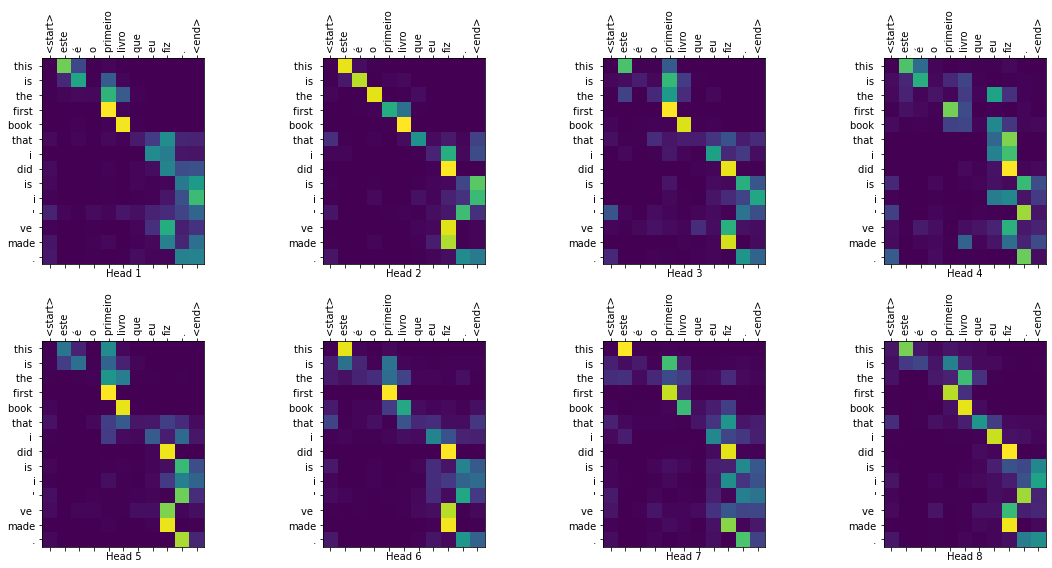

Real translation: this is the first book i've ever done.


In [64]:
#翻訳の実行４（アテンション重み描画付き）
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

## まとめ

このチュートリアルでは、位置エンコーディング、マルチヘッド・アテンション、マスキングの重要性と、 Transformerの作成方法を学習しました。

Transformerを訓練するために、異なるデータセットを使ってみてください。また、上記のハイパーパラメーターを変更してベースTransformerやTransformer XLを構築することもできます。ここで定義したレイヤーを使って[BERT](https://arxiv.org/abs/1810.04805)を構築して、SoTAのモデルを作ることもできます。さらには、より良い予測を得るために、ビームサーチを組み込むこともできます。